In [26]:
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from skimage import io, measure, color
from matplotlib import cm
from skimage.filters import meijering, sato, frangi, hessian, unsharp_mask, threshold_otsu, threshold_mean, threshold_minimum
import sklearn.metrics as metrics
from PIL import Image
from sklearn.metrics import confusion_matrix


In [58]:
#Load images
imageList = []
imageHandLabeledList = []
imageNameList = sorted(glob.glob('img/healthy/*.jpg'))
imageHandLabeledeNameList = sorted(glob.glob('img/healthyHandLabeled/*.tif'))
for filename in imageNameList:
    img = cv2.imread(filename)
    imageList.append(img)

for filename in imageHandLabeledeNameList:
    img = cv2.imread(filename, 0)
    imageHandLabeledList.append(img)

In [59]:
def finalImageStatistics(imgHandLabeled, imgReconstructed):
    conf = confusion_matrix(imgHandLabeled.flatten(), imgReconstructed.flatten())
    TN, FP, FN, TP = conf.ravel()
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))    
    return (accuracy, sensitivity, specificity)

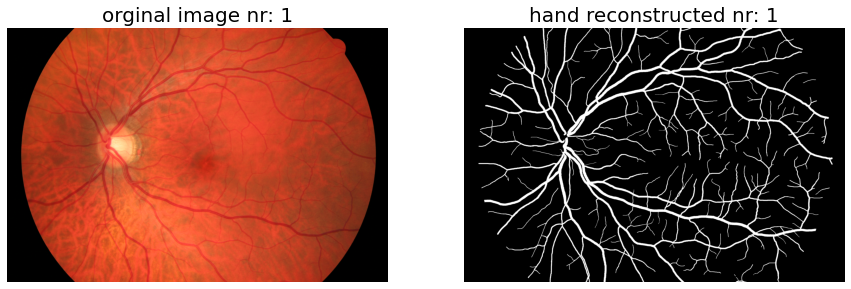

In [60]:
def plotImages(numbers):
    for i in numbers:
        fig, ax = plt.subplots(ncols=2, figsize=(15,15))
        img = cv2.cvtColor(imageList[i], cv2.COLOR_BGR2RGB)
        ax[0].imshow(img), ax[0].axis('off'), ax[0].set_title('orginal image nr: '+str(i), size=20)
        ax[1].imshow(imageHandLabeledList[i], cmap='gray'), ax[1].axis('off'), ax[1].set_title('hand reconstructed nr: ' +str(i), size=20)
    plt.show()

def finalImage(img):
    h = img.shape[0]
    w = img.shape[1]
    finalImage = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if(fov[i][j] == 0):
                continue
            finalImage[i][j] = img[i][j]
    return finalImage

plotImagesList = [1]
plotImages(plotImagesList)

(<matplotlib.image.AxesImage at 0x22501059130>,
 (-0.5, 3503.5, 2335.5, -0.5),
 Text(0.5, 1.0, 'img b'))

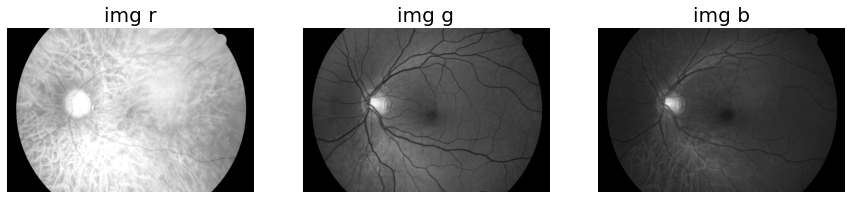

In [61]:
def loadImage(id):
    image = imageList[id]
    imageR = image[:,:,2]
    imageG = image[:,:,1]
    imageB= image[:,:,0]
    return image, imageR, imageG, imageB

image, imageR, imageG, imageB = loadImage(1)
fig, ax = plt.subplots(ncols=3, figsize=(15,15))
ax[0].imshow(imageR, cmap='gray'), ax[0].axis('off'), ax[0].set_title('img r', size=20)
ax[1].imshow(imageG, cmap='gray'), ax[1].axis('off'), ax[1].set_title('img g', size=20)
ax[2].imshow(imageB, cmap='gray'), ax[2].axis('off'), ax[2].set_title('img b', size=20)

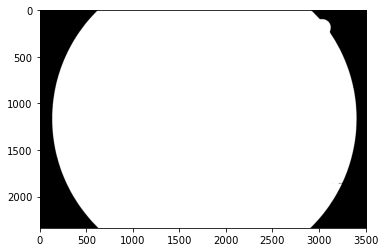

In [62]:
def createFov(image):
    imgGrayscale = color.rgb2gray(image)
    thresh = threshold_minimum(imgGrayscale,100)
    bw, fov = cv2.threshold(imgGrayscale, thresh, 1, cv2.THRESH_BINARY)
    return fov
#fov = createFov(image)
#plt.imshow(fov, cmap='gray'), plt.axis('off'), plt.title('img fov', size=20)

#imageGrayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgGrayscale = color.rgb2gray(image)
thresh = threshold_minimum(imgGrayscale,100)
bw, fov = cv2.threshold(imgGrayscale, thresh, 1, cv2.THRESH_BINARY)

plt.imshow(fov ,cmap='gray')


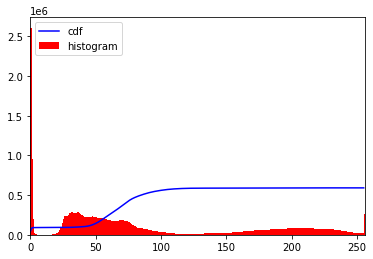

In [63]:
def createHistogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
createHistogram(imageG)

(<matplotlib.image.AxesImage at 0x2250141da60>,
 (-0.5, 7007.5, 2335.5, -0.5),
 Text(0.5, 1.0, 'compare result: image g channel/ normalized image'))

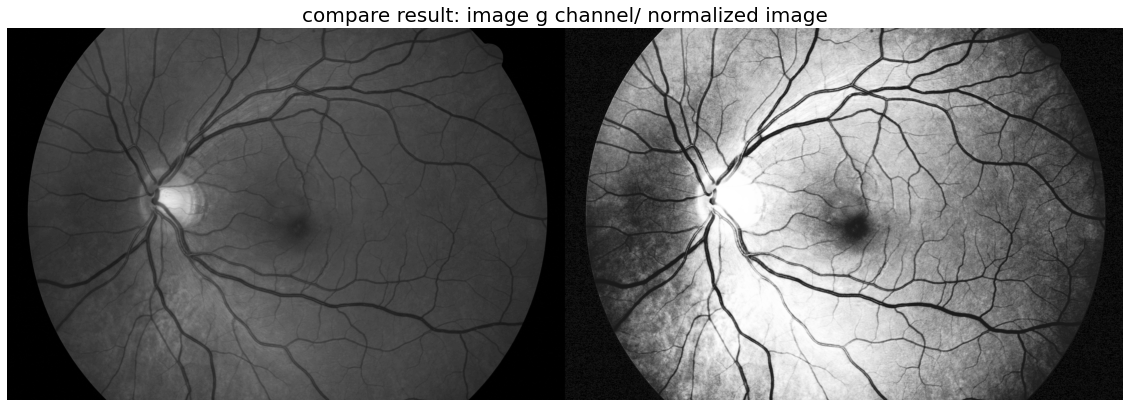

In [64]:
def createEqualizedImage(imgToEqualize):
    equalizedImage = cv2.equalizeHist(imgToEqualize)
    return equalizedImage

equalizedImage = createEqualizedImage(imageG)
res = np.hstack((imageG, equalizedImage)) 
figure(figsize=(20,20))
plt.imshow(res,  cmap='gray'), plt.axis('off'), plt.title('compare result: image g channel/ normalized image', size=20)

(<matplotlib.image.AxesImage at 0x22501648cd0>,
 (-0.5, 3503.5, 2335.5, -0.5),
 Text(0.5, 1.0, 'sharpen image: with matrix'))

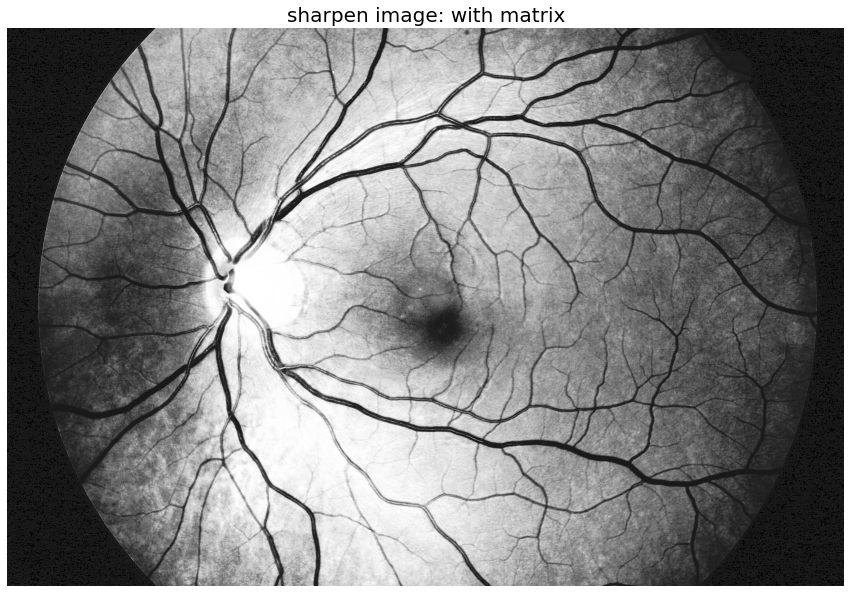

In [65]:
def sharpen(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

sharp = sharpen(equalizedImage)
figure(figsize=(15,15))
plt.imshow(sharp,  cmap='gray'), plt.axis('off'), plt.title('sharpen image: with matrix', size=20)


<ipython-input-66-248a07ac6f1b>:2: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  satoFilter = sato(imageG)


(<matplotlib.image.AxesImage at 0x225016a0580>,
 (-0.5, 3503.5, 2335.5, -0.5),
 Text(0.5, 1.0, 'sato filter'))

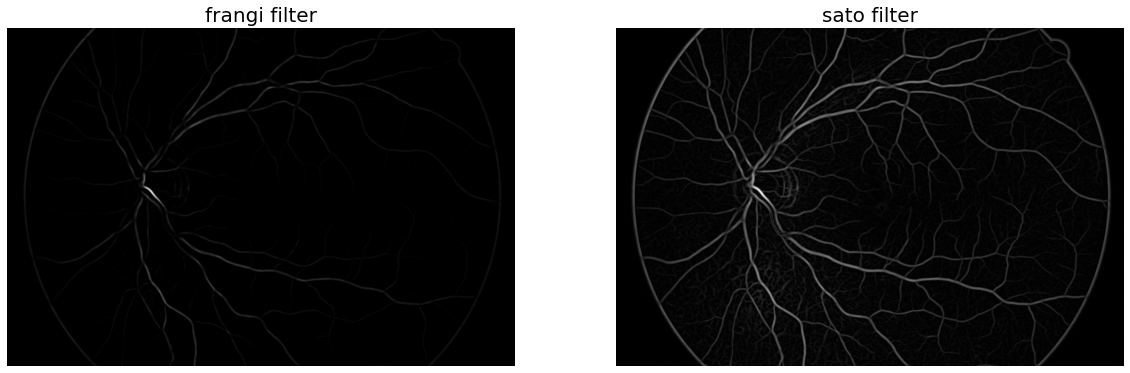

In [66]:
frangi_result = frangi(imageG)
satoFilter = sato(imageG)
res2 = np.hstack((satoFilter, frangi_result)) 

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(frangi_result, cmap='gray'), ax[0].axis('off'), ax[0].set_title('frangi filter', size=20)
ax[1].imshow(satoFilter, cmap='gray'), ax[1].axis('off'), ax[1].set_title('sato filter', size=20)

(<matplotlib.image.AxesImage at 0x22501733c10>,
 (-0.5, 3503.5, 2335.5, -0.5),
 Text(0.5, 1.0, 'handlabeled'))

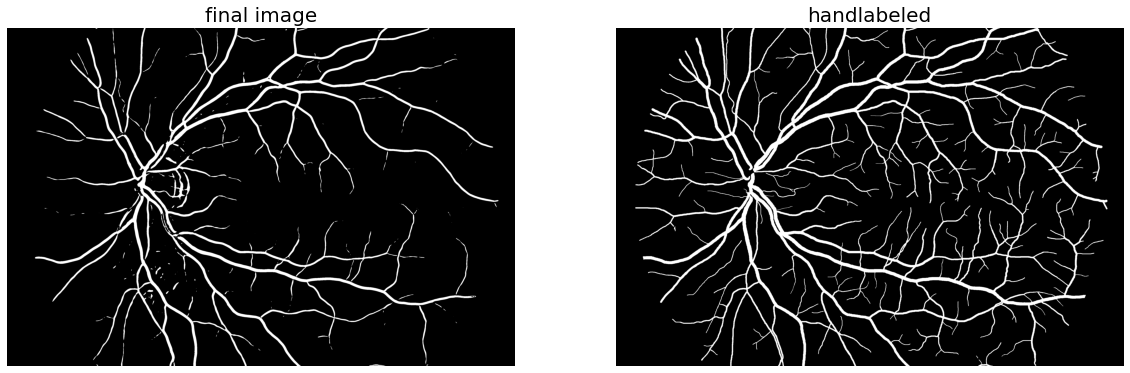

In [67]:
processedImage = finalImage(satoFilter)
thresh = threshold_otsu(processedImage)
processedImage = cv2.inRange(processedImage, thresh, 1)

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(processedImage, cmap='gray'), ax[0].axis('off'), ax[0].set_title('final image', size=20)
ax[1].imshow(imageHandLabeledList[1], cmap='gray'), ax[1].axis('off'), ax[1].set_title('handlabeled', size=20)

In [68]:
(accuracy, sensitivity, specificity) = finalImageStatistics(imageHandLabeledList[0], processedImage)
print(accuracy, sensitivity, specificity)

0.8498146198864702 0.0782395237729767 0.9373356788097487


<ipython-input-56-5c1c5dcacb56>:6: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  sf = sato(sh)


1. accuracy: 0.9530797972571464, sensitivity: 0.5558076191371509, specificity: 0.9966170098954765
2. accuracy: 0.9417734917432914, sensitivity: 0.48783747661053195, specificity: 0.9953548427280711
3. accuracy: 0.9560474184102709, sensitivity: 0.5734194227327336, specificity: 0.9958702372067658
4. accuracy: 0.9542689959029211, sensitivity: 0.5146835484159148, specificity: 0.997881034432284
5. accuracy: 0.9520240077875775, sensitivity: 0.5689204333208816, specificity: 0.9952470772107956


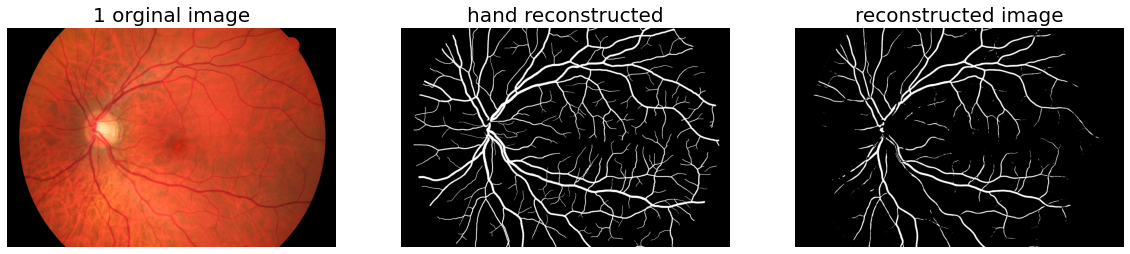

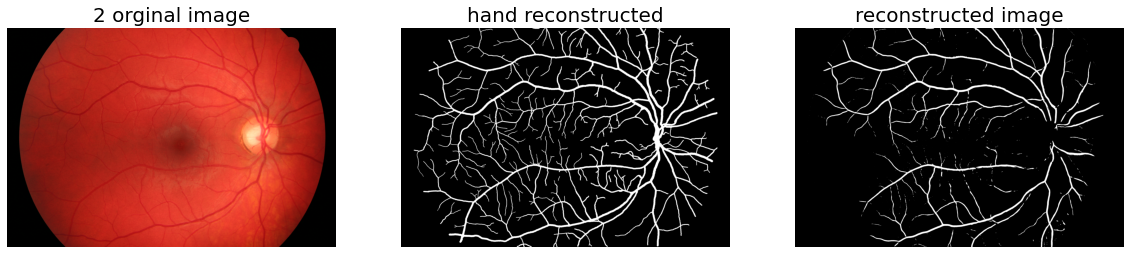

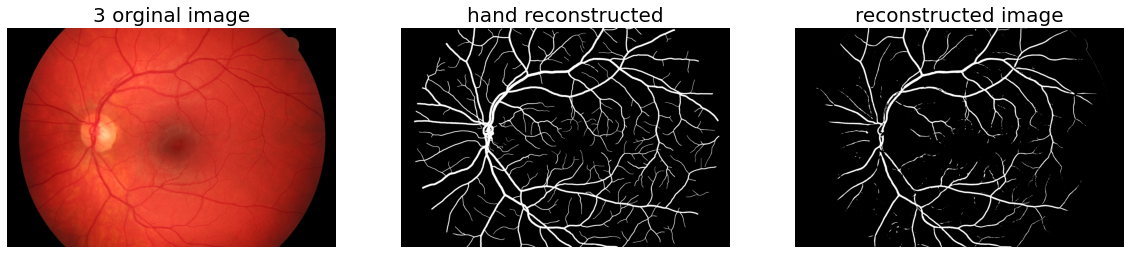

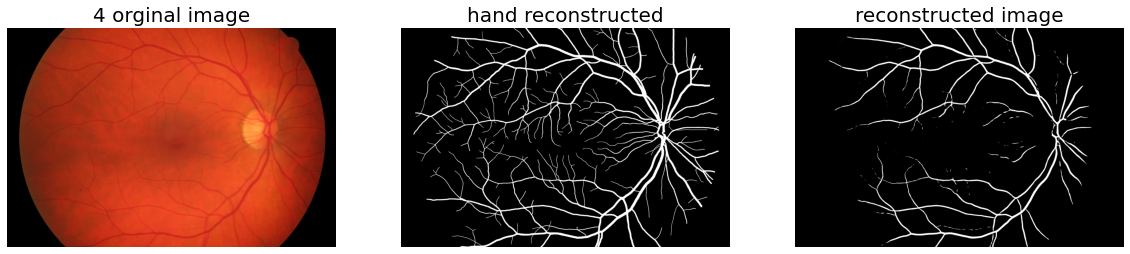

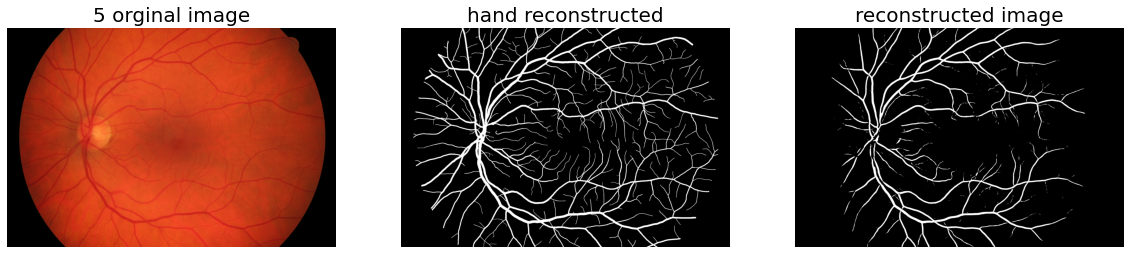

In [69]:
for i in range(1,6):
    processReconstruction(i)

In [70]:
def processReconstruction(id):
    img, imgr, imgg, imgb = loadImage(id)   
    #fov = createFov(img)
    eqimg = createEqualizedImage(imgg)
    sh = sharpen(eqimg)
    sf = sato(sh)
    fi = finalImage(sf)
    th = threshold_otsu(fi)
    ffi = cv2.inRange(fi, th, 1)
    (accuracy, sensitivity, specificity) = finalImageStatistics(imageHandLabeledList[id], ffi)
    fig, ax = plt.subplots(ncols=3, figsize=(20,20))
    orginalImage = cv2.cvtColor(imageList[id], cv2.COLOR_BGR2RGB)
    ax[0].imshow(orginalImage), ax[0].axis('off'), ax[0].set_title(f'{i} orginal image', size=20)
    ax[1].imshow(imageHandLabeledList[i], cmap='gray'), ax[1].axis('off'), ax[1].set_title('hand reconstructed', size=20)
    ax[2].imshow(ffi, cmap='gray'), ax[2].axis('off'), ax[2].set_title('reconstructed image', size=20)
    print(f'{i}. accuracy: {accuracy}, sensitivity: {sensitivity}, specificity: {specificity}')
    